In [5]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

## Neural Ordinary differential Equations
This notebook is adapted from Chen's ode_demo.py in https://github.com/rtqichen/torchdiffeq.  

Begin with the idea of residual networks or recurrent networks defined by

$$
y_{i+1} ~=~ y_i ~+~ N_i(y_i)  ~~~~ i ~=~ 0 ~...~ N
$$
we can see this as
$$
\frac{y_{i+1}-y_i}{\delta i} ~=~ \frac{N_i(y_i)}{\delta i}
$$
if we have the differential equation dy/dx = f(x) then
euler's method is 
$$
y_{i+1} - y_i  ~=~ f(x_i)(x_{i+1}-x_i) ~=~ f(x_i)\delta x
$$
or 
$$
\frac{y_{i+1} - y_i}{\delta x_i} ~=~ f(x_i)
$$
consider simple case
$$
\frac{dy}{dt} ~=~ Net(y,\theta, ~t)
$$
the solution for y given an initial point y_0 and t_0 is given by

$$
y_n, y_{n-1}, ~...~ y_2, y_1 = ODESolver(Net, y_0, t_0, t_n)
$$


In this note book we look at a slightly modified version of the ode_demy.py example provided by the authors.
we will take our sample data from the solution of a simple ODE that generates spirals in 2-D given by
$$
\frac{dy}{dt} ~=~ y * \begin{bmatrix} 
-0.1 & 1.0 \\
-1.0 & -0.1\\
\end{bmatrix}
$$

In [51]:
method='dopri5'
data_size=1000
batch_time=10
batch_size=20
niters=2000
test_freq=10
viz='store_true'
gpu=0
adjoint='store_true'
args = ''

In [52]:
from torchdiffeq import odeint_adjoint as odeint


In [53]:
device = 'cpu'

### create the training data

In [54]:
true_y0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., data_size)
true_A = torch.tensor([[-0.1, 1.0], [-1.0, -0.1]])

In [55]:
t.shape

torch.Size([1000])

In [56]:
class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.mm(y, true_A)

In [57]:
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

In [58]:
py =true_y.numpy()

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
py[1,0]

array([1.9943769 , 0.04991974], dtype=float32)

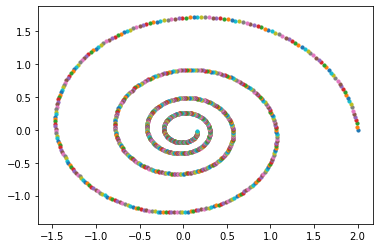

In [61]:

for j in range(int(len(py))):
    zx = py[j,0,0]
    zy = py[j,0,1]
    plt.scatter(zx, zy, s=10)



In [93]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y


In [102]:
by0, bt, by =get_batch()

In [103]:
by.shape

torch.Size([10, 20, 1, 2])

In [104]:
bt

tensor([0.0000, 0.0250, 0.0501, 0.0751, 0.1001, 0.1251, 0.1502, 0.1752, 0.2002,
        0.2252])

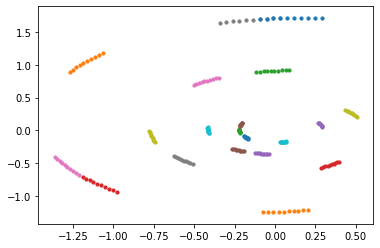

In [105]:
for k in range(10):
    for j in range(20):
        x = by[k,j,0,0]
        y = by[k,j,0,1]
        plt.scatter(x, y, s=10)

In [68]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)


In [69]:
def visualize(true_y, pred_y, odefunc, itr):

    if viz:
        fig = plt.figure(figsize=(12, 4), facecolor='white')
        ax_traj = fig.add_subplot(131, frameon=False)
        ax_phase = fig.add_subplot(132, frameon=False)
        ax_vecfield = fig.add_subplot(133, frameon=False)

        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.numpy(), true_y.numpy()[:, 0, 0], t.numpy(), true_y.numpy()[:, 0, 1], 'g-')
        ax_traj.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--', t.numpy(), pred_y.numpy()[:, 0, 1], 'b--')
        ax_traj.set_xlim(t.min(), t.max())
        ax_traj.set_ylim(-2, 2)
        ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(-2, 2)
        ax_phase.set_ylim(-2, 2)

        ax_vecfield.cla()
        ax_vecfield.set_title('Learned Vector Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[-2:2:21j, -2:2:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2))).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(-2, 2)
        ax_vecfield.set_ylim(-2, 2)
        fig.tight_layout()
        plt.draw()
        plt.pause(0.001)
        plt.show(block=False)


In [70]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

Iter 0010 | Total Loss 0.539661


No handles with labels found to put in legend.


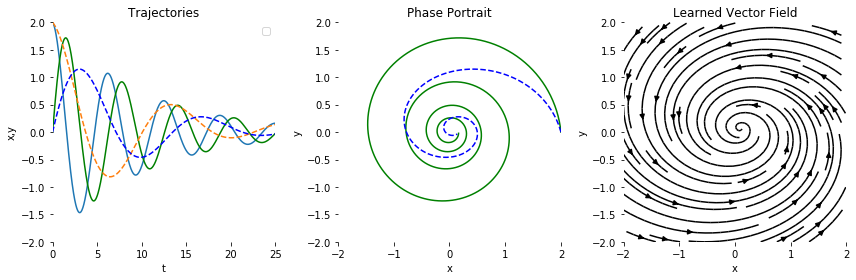

Iter 0020 | Total Loss 0.482775


No handles with labels found to put in legend.


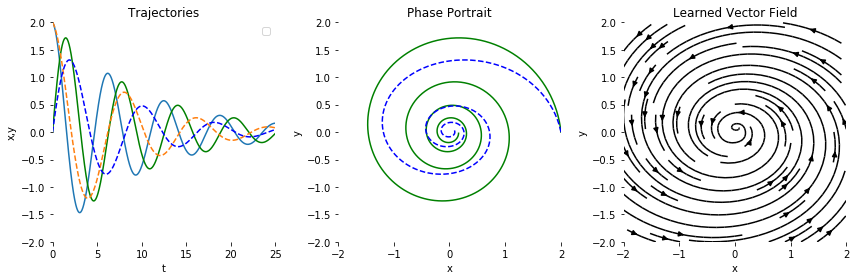

Iter 0030 | Total Loss 0.205306


No handles with labels found to put in legend.


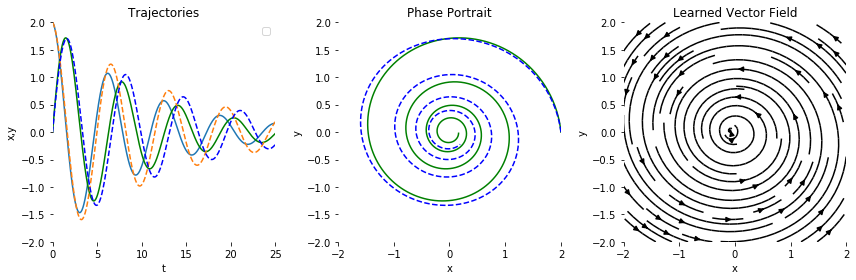

Iter 0040 | Total Loss 0.044974


No handles with labels found to put in legend.


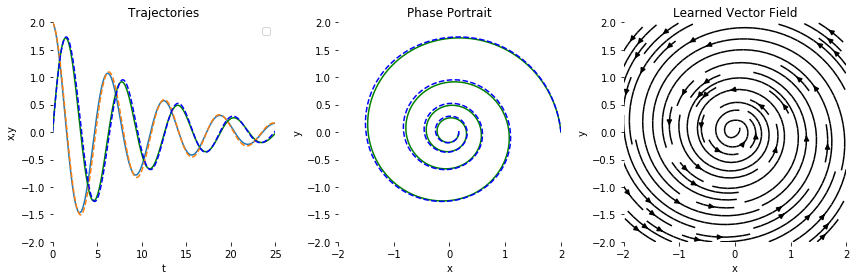

Iter 0050 | Total Loss 0.036806


No handles with labels found to put in legend.


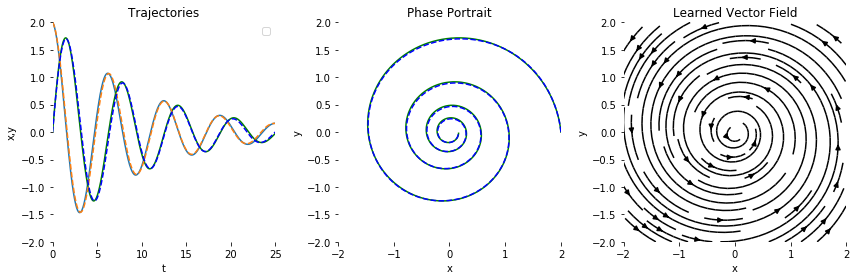

Iter 0060 | Total Loss 0.037240


No handles with labels found to put in legend.


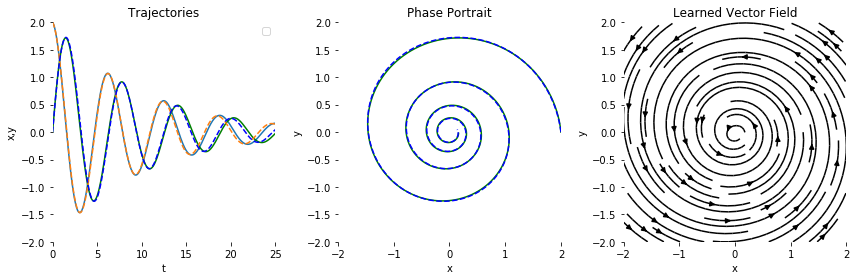

In [73]:
ii = 0
func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
niters = 60
for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, func, ii)
            ii += 1

    end = time.time()


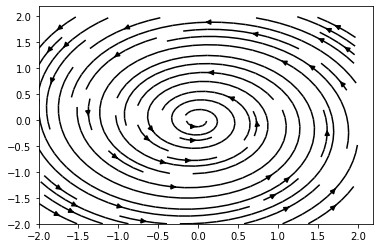

In [96]:
y, x = np.mgrid[-2:2:7j, -2:2:7j]
dydt = func(0.2, torch.Tensor(np.stack([x, y], -1).reshape(7 * 7, 2))).detach().numpy()
mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
dydt = dydt.reshape(7, 7, 2)
plt.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")

Let's show a solution with a different initial condition

In [85]:
y0 = torch.tensor([[10.0,10.0]])

In [86]:
pred_y = odeint(func, y0, t)

In [87]:
py = pred_y.detach().numpy()

In [89]:
len(py)

1000

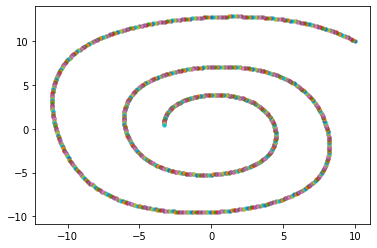

In [88]:
for j in range(int(len(py))):
    zx = py[j,0,0]
    zy = py[j,0,1]
    plt.scatter(zx, zy, s=10)
